In [7]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# library for sampling 
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, SVMSMOTE

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, precision_recall_fscore_support, confusion_matrix, roc_curve, make_scorer
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


import shap

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
X_base = pd.read_csv(r"C:\Users\jongb\bank_marketing\data\X_base.csv")
y_encoded = pd.read_csv(r"C:\Users\jongb\bank_marketing\data\Y_encoded.csv")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_base, y_encoded, test_size=0.2, stratify=y_encoded)

In [4]:
LOCAL_HOST = "http://127.0.0.1:5000"
EXPERIMENT_NAME = "bank_marketing_model"

In [5]:
import mlflow

mlflow.set_tracking_uri(LOCAL_HOST)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/830362473760211760', creation_time=1734936396916, experiment_id='830362473760211760', last_update_time=1734936396916, lifecycle_stage='active', name='bank_marketing_model', tags={'mlflow.sharedViewState.d914317102b47fc2dddb735433646b289e5cc69c1f1d2d40d7515ef7795d0fd5': 'deflate;eJxtUsFu2zAM/ZVB56Bor7m5WboVS4rC6YIBwZAoEh0ToCRDlLp4Rf59dJzGXrcj3+Mj+Ui+KQYdTf2AlCCqqVITFaKFeN9+g1ZiBymi4ZtdBKOJtsFvE3DaDXkFGzWtNDFMFCcd0ws6EGWxWEgSYQWmNQTXDoVJ+ApCWZ00Q+J3ZvNzolywQGuIjMEPCqJPZfYsGgYCk8DOAmUnyHSjdJIJ91mmutmtQo4GuuHG6LIryh/Rz337Dr6arO7YhAhjl1eukQ1gN9d/2X/XM1DBjPFGR+0EZu0aQn/YKfEdxd782Ghvwarp26lHntH7Lt5cMr6iteCHeC3z7JEwtUvdDLI+rXMty3t4LFcv27vbbfn9aSXtXxF+LfURHf7uSl8OJ7IFcnpvcEGRCyP7sGK6hPO5R5LM8CWG3IBda8rAj35Wy/XlJilm4Wu0MHdNav+GD53mXl7LZ6JL+MG6zimUUEXgeu71nkZNDxT2mhbo4Vx1FnyFB1GpY3FE7l+WEzTnz/OwciGk2gNL+9vhe350ycvzfXqJOp3+AFCuF+Y='}>

## 1.XGBoost Base Model 

In [8]:
params = {'n_estimators': 1335, 
          'max_depth': 25,
          'learning_rate': 0.015,
          'gamma': 0.43297172902387754, 
          'subsample': 0.7940159600934609,
          'min_child_weight': 1.3007171470331855,
          'eval_metric' : 'logloss',
          'objective' :'binary:logistic',
          'reg_lambda': 0.22985958150861197,
          'reg_alpha': 1.1710987441793046,
          'colsample_bytree': 0.6191155411476719
          }

In [20]:
RANDOM_STATE = 42
N_SPLIT = 3

N_ESTI = 1335
MAX_DEPTH = 25
LEARNING_RATE = 0.01
OBJ = 'binary:logistic'

In [21]:
skf = StratifiedKFold(n_splits=N_SPLIT, random_state=RANDOM_STATE, shuffle=True)

In [22]:
model = xgb.XGBClassifier(n_estimators=N_ESTI,
                          max_depth=MAX_DEPTH,
                          learning_rate=LEARNING_RATE,
                          objective=OBJ,
                          random_state=RANDOM_STATE)

In [31]:
def train_fnc(X_train_data, 
              y_train_data,
              X_test_data,
              y_test_data, 
              cv, 
              model,
              sampling=None):
        
    with mlflow.start_run():

        # Logging parameters
        mlflow.log_param("split_num", N_SPLIT)
        mlflow.log_param("n_estimators", N_ESTI)
        mlflow.log_param("max_depth", MAX_DEPTH)
        mlflow.log_param("learning_rate", LEARNING_RATE)
        mlflow.log_param("sampling", sampling)
    

        # Metrics collection
        list_fold_result_val, list_fold_result_test = [], []
        list_fold_roc_val, list_fold_roc_test = [], []

        for i, (train_index, val_index) in enumerate(cv.split(X_train_data, y_train_data)):
            print(f"Fold {i+1}")

            # Data split
            X_train_cv, X_val_cv = X_train_data.iloc[train_index, :], X_train_data.iloc[val_index, :]
            y_train_cv, y_val_cv = y_train_data.iloc[train_index], y_train_data.iloc[val_index]
            

            # Model training
            
            model.fit(X_train_cv, y_train_cv)

            # Validation set evaluation
            y_pred_val = model.predict(X_val_cv)
            y_pred_proba_val = model.predict_proba(X_val_cv)[:, -1]
            roc_val = roc_auc_score(y_val_cv, y_pred_proba_val)
            prf_val = precision_recall_fscore_support(y_val_cv, y_pred_val, average='macro')

            print(f"val_precision: {prf_val[0]} val_recall: {prf_val[1]} val_f1: {prf_val[2]}")
            print(f"val_auc score: {roc_val}")


            list_fold_result_val.append(prf_val)
            list_fold_roc_val.append(roc_val)

    

        # Average metrics calculation
        def get_prf_average(results, n_split):
            pre, rec, f1 = 0, 0, 0
            for res in results:
                pre += res[0]
                rec += res[1]
                f1 += res[2]
            return pre/n_split, rec/n_split, f1/n_split
        

        val_precision, val_recall, val_f1 = get_prf_average(list_fold_result_val, N_SPLIT)
        val_roc = sum(list_fold_roc_val) / N_SPLIT

        # test set evaluation
        y_pred_test = model.predict(X_test_data)
        y_pred_proba_test = model.predict_proba(X_test_data)[:, -1]
        test_roc = roc_auc_score(y_test_data, y_pred_proba_test)
        prf_test = precision_recall_fscore_support(y_test_data, y_pred_test, average='macro')

        test_precision = prf_test[0]
        test_recall = prf_test[1]
        test_f1 = prf_test[2]
        print("=================Test score =====================")
        print(f"test_precision: {test_precision} test_recall: {test_recall} test_f1: {test_f1}")
        print(f"test_auc score: {test_roc}")

        # Log metrics
        mlflow.log_metric("precision_on_val", val_precision)
        mlflow.log_metric("recall_on_val", val_recall)
        mlflow.log_metric("f1score_on_val", val_f1)
        mlflow.log_metric("roc_on_val", val_roc )

        mlflow.log_metric("precision_on_test", test_precision)
        mlflow.log_metric("recall_on_test", test_recall)
        mlflow.log_metric("f1score_on_test", test_f1)
        mlflow.log_metric("roc_on_test", test_roc)

        def save_artifacts(model, X, y, pred):
        # ROC Curve
            plt.figure()  
            roc_display = RocCurveDisplay.from_estimator(model, X, y)
            roc_display.ax_ = plt.gca() 
            roc_display.figure_ = plt.gcf()  
            plt.title("ROC Curve")
            plt.savefig('roc_curve.png')
            plt.show()  
            plt.clf()  
            mlflow.log_artifact('roc_curve.png')  

            # Confusion Matrix
            conf_matrix = confusion_matrix(y, pred)
            plt.figure()  
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.title("Confusion Matrix")
            plt.savefig('conf_matrix.png')  
            plt.show()  
            plt.clf()  
            mlflow.log_artifact('conf_matrix.png') 



        save_artifacts(model, X_test_data, y_test_data, y_pred_test)
        mlflow.sklearn.log_model(model, "model")

    mlflow.end_run()

Fold 1
val_precision: 0.7703494438805845 val_recall: 0.7390484771480733 val_f1: 0.7533073533864935
val_auc score: 0.9349563490683899
Fold 2
val_precision: 0.7745371129429303 val_recall: 0.7350768011957427 val_f1: 0.7526131069844557
val_auc score: 0.9398981471347999
Fold 3
val_precision: 0.7780386544861847 val_recall: 0.7269154788160826 val_f1: 0.7487942548958186
val_auc score: 0.9360098592020256
=================Test score =====================
test_precision: 0.7836747801435356 test_recall: 0.7356920498084292 test_f1: 0.7565339406236513
test_auc score: 0.9412457474567313


<Figure size 640x480 with 0 Axes>

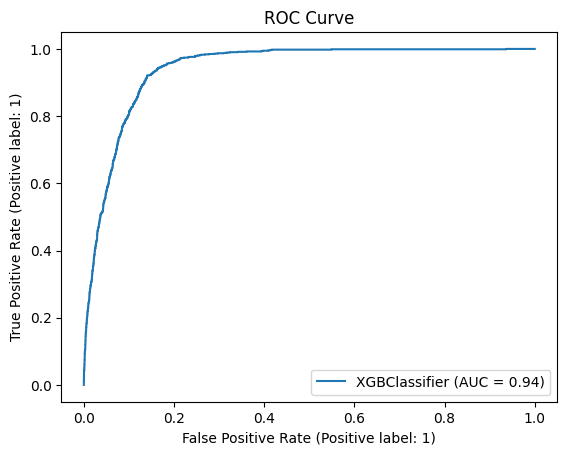

<Figure size 640x480 with 0 Axes>

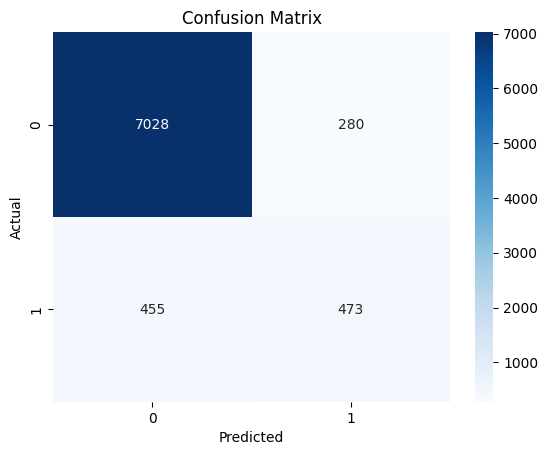

2024/12/23 13:11:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run thoughtful-shad-631 at: http://127.0.0.1:5000/#/experiments/830362473760211760/runs/a2824d2fe4d24e0080901a9772114047
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/830362473760211760


<Figure size 640x480 with 0 Axes>

In [24]:
train_fnc(X_train,
          y_train,
          X_test,
          y_test,
          skf,
          model)

### 1=2 Optimization with Sampling
1. SMOTE
2. SMOTEEN

In [36]:
# 1. SMOTE
SAMPLING = 'SMOTE'
sm = SMOTE(random_state=RANDOM_STATE)
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

Fold 1
val_precision: 0.9510700789253795 val_recall: 0.9507338602073283 val_f1: 0.9507246779946465
val_auc score: 0.9925196244078378
Fold 2
val_precision: 0.9498863454077422 val_recall: 0.9495535256081289 val_f1: 0.9495441939783624
val_auc score: 0.9920534931354827
Fold 3
val_precision: 0.9484947464092743 val_recall: 0.9480139587396079 val_f1: 0.9480000227079681
val_auc score: 0.9914407161305112
=================Test score =====================
test_precision: 0.761246699689398 test_recall: 0.7944290503557745 test_f1: 0.7763346677690206
test_auc score: 0.9412784820130985


<Figure size 640x480 with 0 Axes>

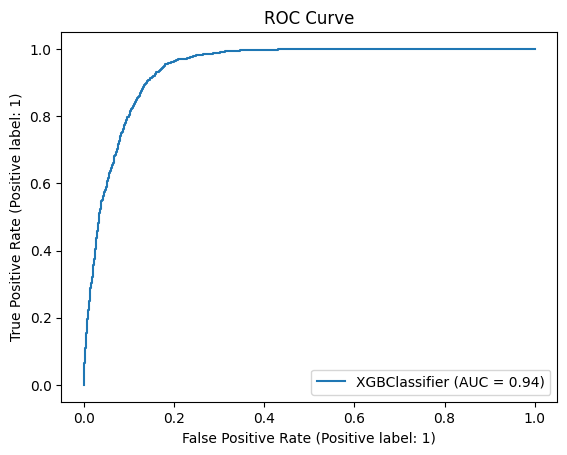

<Figure size 640x480 with 0 Axes>

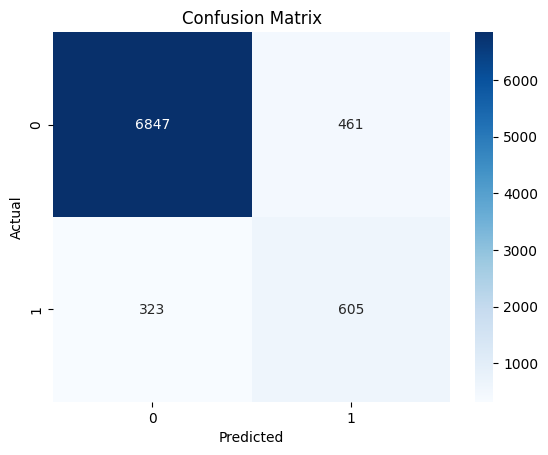

2024/12/23 19:42:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bedecked-fawn-594 at: http://127.0.0.1:5000/#/experiments/830362473760211760/runs/0bd9db1dfb2044b6a92538b31a679e74
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/830362473760211760


<Figure size 640x480 with 0 Axes>

In [37]:
train_fnc(X_sm_sampling,
          y_sm_sampling,
          X_test,
          y_test,
          skf,
          model,
          sampling=SAMPLING)

In [34]:
# 2. SMOTEEN
SAMPLING = 'SMOTEEN'
combined_sm = SMOTEENN(random_state=RANDOM_STATE)
X_csm_sampling, y_csm_sampling = combined_sm.fit_resample(X_train, y_train)

Fold 1
val_precision: 0.980006678924529 val_recall: 0.9787155218259715 val_f1: 0.9792904785190426
val_auc score: 0.9981097735617369
Fold 2
val_precision: 0.9776885443245531 val_recall: 0.9756963815680082 val_f1: 0.9765385271452571
val_auc score: 0.9980373692902006
Fold 3
val_precision: 0.9787010627982504 val_recall: 0.9771897207974813 val_f1: 0.9778514332041084
val_auc score: 0.9980350934832989
=================Test score =====================
test_precision: 0.7417322711743439 test_recall: 0.8493944991789819 test_f1: 0.7795257333586453
test_auc score: 0.9421009746050619


<Figure size 640x480 with 0 Axes>

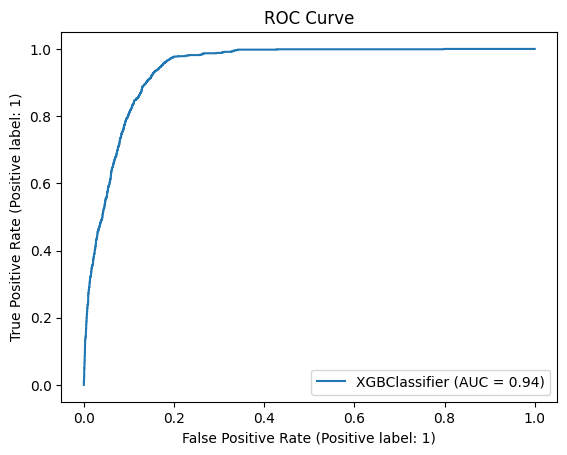

<Figure size 640x480 with 0 Axes>

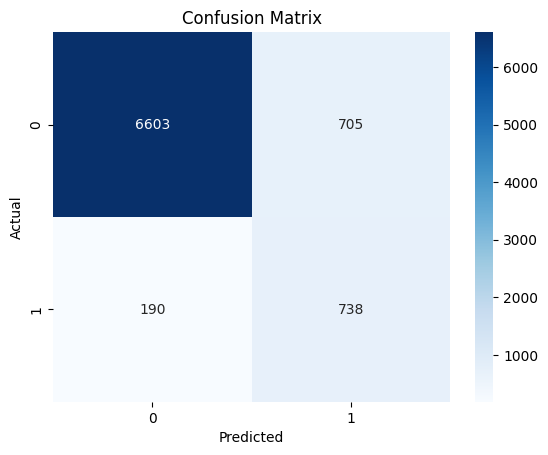

2024/12/23 19:26:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run skittish-shrimp-637 at: http://127.0.0.1:5000/#/experiments/830362473760211760/runs/cd5b41719b29469d98b42dfbfbcd1b09
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/830362473760211760


<Figure size 640x480 with 0 Axes>

In [35]:
train_fnc(X_csm_sampling,
          y_csm_sampling,
          X_test,
          y_test,
          skf,
          model,
          sampling=SAMPLING)

## GridSearch

In [49]:
from xgboost import XGBClassifier

In [39]:
# Custom scorer for GridSearchCV
def precision_macro_scorer(y_true, y_pred):
    precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return precision

def recall_macro_scorer(y_true, y_pred):
    _, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return recall

def f1_macro_scorer(y_true, y_pred):
    _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return f1

scoring = {
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, average='macro'),
    'precision_macro': make_scorer(precision_macro_scorer),
    'recall_macro': make_scorer(recall_macro_scorer),
    'f1_macro': make_scorer(f1_macro_scorer)}

In [50]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [20, 30, 50]
}

# StratifiedKFold CV
cv = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=RANDOM_STATE)

# Initialize the model
xgb_model = XGBClassifier(random_state=RANDOM_STATE)


# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',  # Optimize for ROC AUC
    cv=cv,
    verbose=1,
    return_train_score=True
)

with mlflow.start_run():

    # Fit the GridSearchCV
    grid_search.fit(X_csm_sampling, y_csm_sampling)

    # Log the best parameters
    best_params = grid_search.best_params_
    mlflow.log_param("best_n_estimator", best_params['n_estimator'])
    mlflow.log_param("best_learning_rate", best_params['learning_rate'])
    mlflow.log_param("best_max_depth", best_params['max_depth'])
    mlflow.log_param("sampling", 'SMOTEEN')
    mlflow.log_param("model", 'XGB')

    # Log the best scores
    best_roc_auc = grid_search.best_score_
    mlflow.log_metric("best_roc_auc", best_roc_auc)

    # Best model evaluation on test set
    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(X_test)
    y_pred_proba_test = best_model.predict_proba(X_test)[:, -1]
    test_roc = roc_auc_score(y_test, y_pred_proba_test)
    prf_test = precision_recall_fscore_support(y_test, y_pred_test, average='macro')

    test_precision, test_recall, test_f1 = prf_test[0], prf_test[1], prf_test[2]

    # Log test metrics
    mlflow.log_metric("precision_on_test", test_precision)
    mlflow.log_metric("recall_on_test", test_recall)
    mlflow.log_metric("f1score_on_test", test_f1)
    mlflow.log_metric("roc_on_test", test_roc)

    print("================= Test Scores =====================")
    print(f"Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}, ROC AUC: {test_roc}")

    # Save artifacts
    def save_artifacts(model, X, y, pred):
        # ROC Curve
        plt.figure()
        RocCurveDisplay.from_estimator(model, X, y)
        plt.title("ROC Curve")
        plt.savefig('roc_curve.png')
        plt.show()
        plt.clf()
        mlflow.log_artifact('roc_curve.png')

        # Confusion Matrix
        conf_matrix = confusion_matrix(y, pred)
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title("Confusion Matrix")
        plt.savefig('conf_matrix.png')
        plt.show()
        plt.clf()
        mlflow.log_artifact('conf_matrix.png')

    save_artifacts(best_model, X_test, y_test, y_pred_test)

    # Log the best model
    mlflow.sklearn.log_model(best_model, "best_model")

mlflow.end_run()

Fitting 3 folds for each of 27 candidates, totalling 81 fits
🏃 View run trusting-crow-663 at: http://127.0.0.1:5000/#/experiments/830362473760211760/runs/8bd6cadd24b34a77ae63b42a52d8e288
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/830362473760211760


KeyError: 'n_estimator'